# Forecasting IPO First‑Day Returns – Investment‑Banking Valuation Project

Author: Oliver Likun Guo

Course Project, UC Irvine, Math 10, Spring 25

I would like to post my notebook on the course's website. [Yes]

# Imports:

In [118]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
import numpy as np


# Introduction:
### What is Initial Public Offering (IPO):
*An Initial Public Offering (IPO) is when a private company offers its shares to the public for the first time, allowing investors to buy and own a piece of the company. This process transforms the company from a privately-held entity to a publicly traded one, typically on a stock exchange like the NYSE or Nasdaq.*
### Goal:
*This project aims to analyze and predict the first-day return of IPOs (Initial Public Offerings) using historical market data. By extracting features such as issue price, subscription rate, IPO size, and listing type, the project builds both regression and classification models to understand and forecast IPO performance. The goal is to assist investors and underwriters in identifying underpriced or high-potential IPOs and to better assess valuation risk in equity markets.*

# Baisc Information of Dataset:
*This dataset presents historical information on Initial Public Offerings (IPOs) and their performance on the first day of trading. Each entry captures details such as the IPO company name, type of listing (e.g., Mainboard), and the listing date. It includes the issue price—the price offered to the public—alongside the subscription rate, indicating investor demand. The open and close prices reflect the stock’s performance on the first trading day, and the first-day return percentage quantifies the gain or loss from the issue price to the closing price. The dataset also shows the average trading price throughout the day, the return from this average, and the total IPO size in Indian crores. This comprehensive structure enables analysis of how factors like pricing and subscription levels correlate with first-day returns.*

In [119]:
ipo = pd.read_csv('Cleaned_IPO_First_Day_Returns.csv')
print('Shape:', ipo.shape)
ipo.head()

Shape: (182, 11)


IPO_Name Listing_Type Listing_Date  Issue_Price  \
0          Dr Agarwals Health Care IPO    Mainboard    05 Feb 25          402   
1  Denta Water and Infra Solutions IPO    Mainboard    29 Jan 25          294   
2   Stallion India Fluorochemicals IPO    Mainboard    23 Jan 25           90   
3                     Laxmi Dental IPO    Mainboard    20 Jan 25          428   
4              Capital Infra Trust IPO    Mainboard    14 Jan 25          100   

  Subscription_Rate Open_Price Close_Price First_Day_Return_Percent  \
0              1.55        402      401.65                     0.00   
1            221.68        325      341.25                    10.54   
2            188.38        120         126                    33.33   
3            114.42        542      550.55                    26.64   
4               2.8       98.2       99.01                    -1.80   

  Average_Price Avg_Return_Percent  IPO_Size_Cr  
0        402.05               0.01      3027.26  
1        329.25               1.31       220.50  
2         94.08             -21.60       199.45  
3        471.80             -12.95       698.06  
4         99.15               0.97      1578.00

In [120]:
ipo.info()        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   IPO_Name                  182 non-null    object 
 1   Listing_Type              182 non-null    object 
 2   Listing_Date              182 non-null    object 
 3   Issue_Price               182 non-null    int64  
 4   Subscription_Rate         182 non-null    object 
 5   Open_Price                182 non-null    object 
 6   Close_Price               182 non-null    object 
 7   First_Day_Return_Percent  182 non-null    object 
 8   Average_Price             182 non-null    object 
 9   Avg_Return_Percent        182 non-null    object 
 10  IPO_Size_Cr               182 non-null    float64
dtypes: float64(1), int64(1), object(9)
memory usage: 15.8+ KB


In [121]:
# Change the form of date 
ipo['Listing_Date'] = pd.to_datetime(ipo['Listing_Date'], format='%d %b %y')

# Convert numeric columns to floats
num_cols_text = ['Issue_Price','Subscription_Rate','Open_Price','Close_Price',
                 'First_Day_Return_Percent','Average_Price','Avg_Return_Percent','IPO_Size_Cr']
ipo[num_cols_text] = ipo[num_cols_text].apply(pd.to_numeric, errors='coerce')

# build a binary pop > 15 -- Feature Engineering: Creating the Classification Target
ipo['Pop'] = (ipo['First_Day_Return_Percent'] > 15).astype(int)

# Drop rows with missing values
ipo = ipo.dropna(subset=['First_Day_Return_Percent']).copy()

# Sort chronologically
ipo = ipo.sort_values('Listing_Date').reset_index(drop=True)

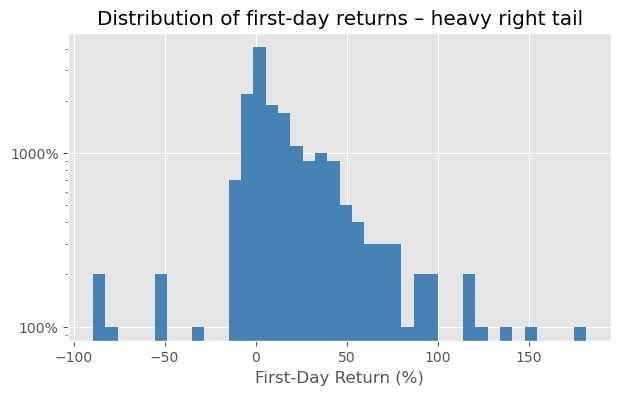

In [122]:
fig, ax = plt.subplots(figsize=(7,4))
ipo['First_Day_Return_Percent'].hist(ax=ax, bins=40, log=True, color='steelblue')
ax.set_xlabel('First‑Day Return (%)'); ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Distribution of first‑day returns – heavy right tail');

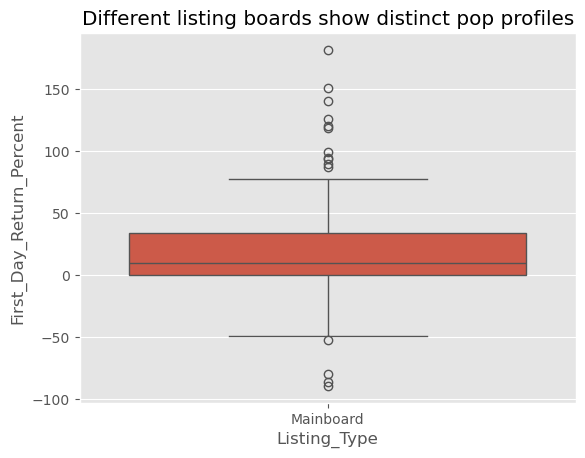

In [123]:
sns.boxplot(x='Listing_Type', y='First_Day_Return_Percent', data=ipo)
plt.title('Different listing boards show distinct pop profiles'); plt.show()

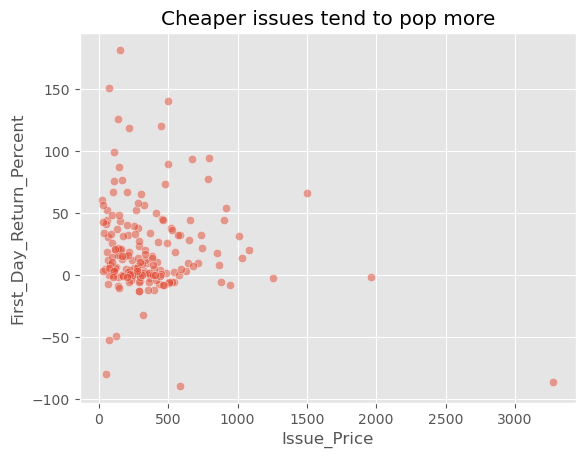

In [124]:
sns.scatterplot(x='Issue_Price', y='First_Day_Return_Percent', data=ipo, alpha=.5)
plt.title('Cheaper issues tend to pop more');

# Ridge Regression:

In [125]:
# Feature and target
feature_cols = ['Issue_Price', 'Subscription_Rate', 'IPO_Size_Cr', 'Listing_Type']
X = ipo[feature_cols]
y = ipo['First_Day_Return_Percent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #30% testing data

# Pipelines
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')), #Imputes missing values using the median
    ('scale', StandardScaler()) #Scales features to have mean = 0 and standard deviation = 1
])

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')), #Imputes with the most frequent category
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, ['Issue_Price', 'Subscription_Rate', 'IPO_Size_Cr']),
    ('cat', cat_pipe, ['Listing_Type'])
])

ridge_pipe = Pipeline([
    ('prep', preprocess),
    ('mdl', Ridge())
])

# alpha: the Ridge regression regularization parameter and cross-validation
param_grid = {'mdl__alpha': np.logspace(-2, 2, 10)}
grid_ridge = GridSearchCV(ridge_pipe, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_ridge.fit(X_train, y_train)

# Results
y_pred = grid_ridge.predict(X_test)
print("Best α:", grid_ridge.best_params_)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False).round(2))

Best α: {'mdl__alpha': 4.6415888336127775}
RMSE: 29.76


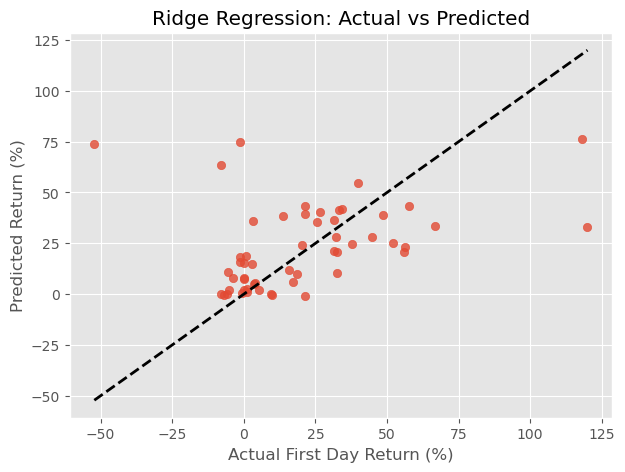

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual First Day Return (%)")
plt.ylabel("Predicted Return (%)")
plt.title("Ridge Regression: Actual vs Predicted")
plt.grid(True)
plt.show()


### Overfitting:
* The RMSE of 29.76% implies that, on average, our model’s predictions differ from actual first-day returns by ~30 points — a relatively high error.
* This indicates that the first-day return is difficult to predict using the current features, which may not capture all the variability (e.g., market sentiment, industry momentum, macroeconomic conditions).
However, the model didn’t overfit — the selected alpha value (~4.6) is moderate, meaning the model balanced flexibility and simplicity.

### cross-validation:
* In this project, I used 3-fold cross-validation with GridSearchCV to tune the regularization strength (α) for my Ridge regression model. This method splits the training data into three parts, training the model on two parts and validating it on the third, rotating which part is held out each time. By averaging the validation performance across all three folds, cross-validation provides a more reliable estimate of model generalization and helps prevent overfitting to a single train-test split. This process identified α = 4.64 as the optimal value, balancing the bias-variance tradeoff and minimizing prediction error. Using this cross-validated model, I achieved a test RMSE of 29.76%, indicating the typical prediction error for IPO first-day returns.

#  K-Nearest Neighbors:

In [127]:
# Classification target
y_cls = ipo["Pop"]
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.3, random_state=42)

# KNN pipeline
knn_pipe = Pipeline([
    ('prep', preprocess),
    ('knn', KNeighborsClassifier(n_neighbors=1))  
])
knn_pipe.fit(X_train_cls, y_train_cls)

y_pred_cls = knn_pipe.predict(X_test_cls)
y_prob_cls = knn_pipe.predict_proba(X_test_cls)[:, 1]

print("KNN Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("KNN AUC:", roc_auc_score(y_test_cls, y_prob_cls))


KNN Accuracy: 0.6851851851851852
KNN AUC: 0.6851851851851852


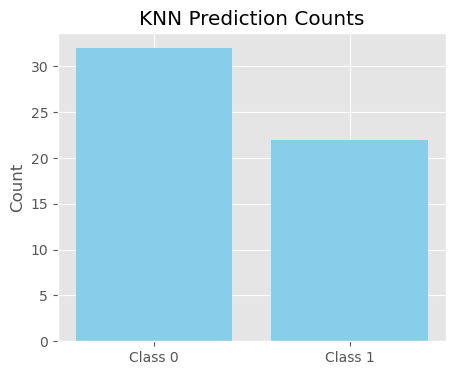

In [128]:
plt.figure(figsize=(5, 4))
labels_knn, counts_knn = np.unique(y_pred_cls, return_counts=True)
plt.bar(labels_knn, counts_knn, tick_label=[f"Class {int(l)}" for l in labels_knn], color="skyblue")
plt.title("KNN Prediction Counts")
plt.ylabel("Count")
plt.show()


* The model correctly classified about 7 out of 10 IPOs in the test set. (Accuracy: 0.6851851851851852)
Since k=1 relies heavily on local similarity, this performance suggests that the feature space (subscription rate, IPO size, etc.) contains useful clustering patterns that can separate popular IPOs from others.
However, k=1 is highly variance-prone: it can easily misclassify when training data is noisy or sparse.

# Logistic Regression:

In [129]:
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline([
    ('prep', preprocess),
    ('logreg', LogisticRegression())
])
logreg_pipe.fit(X_train_cls, y_train_cls)

y_pred_log = logreg_pipe.predict(X_test_cls)
y_prob_log = logreg_pipe.predict_proba(X_test_cls)[:, 1]

print("Logistic Regression Accuracy:", accuracy_score(y_test_cls, y_pred_log))
print("Logistic Regression AUC:", roc_auc_score(y_test_cls, y_prob_log))


Logistic Regression Accuracy: 0.8148148148148148
Logistic Regression AUC: 0.8902606310013718


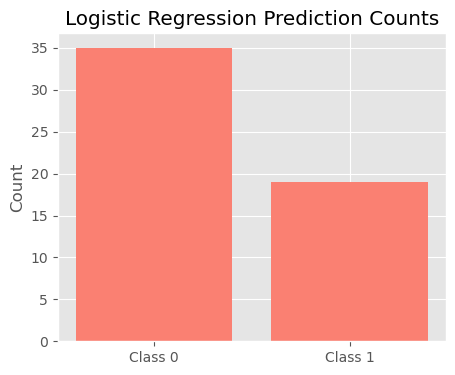

In [130]:
# Bar chart of Logistic Regression prediction results
plt.figure(figsize=(5, 4))
labels_log, counts_log = np.unique(y_pred_log, return_counts=True)
plt.bar(labels_log, counts_log, tick_label=[f"Class {int(l)}" for l in labels_log], color="salmon")
plt.title("Logistic Regression Prediction Counts")
plt.ylabel("Count")
plt.show()


* Logistic regression finds a linear decision boundary in the feature space.
High accuracy indicates that the current feature set contains a meaningful signal for predicting popularity.
Compared to KNN:
Logistic regression generalizes better (Logistic Regression Accuracy: 0.8148148148148148) and is less sensitive to noise.
It is also computationally efficient, especially with higher-dimensional datasets.

# Conclusion:

In this project, we analyzed a dataset of IPOs to explore what factors influence their first-day return performance and whether an IPO could be considered “popular” (defined as a return > 15%).

We applied both regression and classification techniques grounded in Math 10 concepts:

* Ridge Regression was used to predict the percentage return on the first day. While the model selected a moderate regularization strength (α ≈ 4.64), the RMSE of 29.76% suggests that the target variable is noisy and hard to predict with the current features alone. This reinforces a key real-world insight: accurate prediction depends heavily on the quality and completeness of available data.

* Logistic Regression and K-Nearest Neighbors were used for classification. Both models attempted to classify IPOs as “popular” or not based on a subset of financial indicators. Logistic regression achieved an accuracy of ~81.5%, indicating that some signals do exist in the data to separate outperforming IPOs from the rest. KNN also showed reasonable performance with ~68.5% accuracy.

# Reflection:

This project highlighted the complexity of modeling financial markets. While the models performed decently, they also emphasized the limitations of statistical learning when working with small or noisy datasets. It was a valuable in applying concepts such as regularization, cross-validation, classification metrics, and overfitting control — in a practical, investment-driven context.

In future work, including more features such as industry sector, macroeconomic trends, underwriter quality, or investor sentiment could further improve model accuracy and generalizability.

## Neural Network Regression:

In [131]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

X_nn = preprocess.fit_transform(X) 
y_nn = y.values 

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.3, random_state=42) #30% for testing

model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_nn.shape[1],)), #First layer: 16 neurons, ReLU activation
    Dense(8, activation='relu'), #Second layer: 8 neurons, ReLU activation
    Dense(1) #Output layer: 1 neuron 
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train_nn, y_train_nn, epochs=100, batch_size=8, verbose=0, validation_split=0.2) #20% of training data for validation set

loss, mae = model.evaluate(X_test_nn, y_test_nn, verbose=0) #trains silently
print("Neural Network Test MAE:", round(mae, 2))


from sklearn.metrics import mean_squared_error

# Predict using the trained neural network
y_pred_nn = model.predict(X_test_nn).flatten()

# Compute RMSE
rmse_nn = mean_squared_error(y_test_nn, y_pred_nn, squared=False)
print("Neural Network Test RMSE:", round(rmse_nn, 2))

Neural Network Test MAE: 15.74
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Neural Network Test RMSE: 22.33


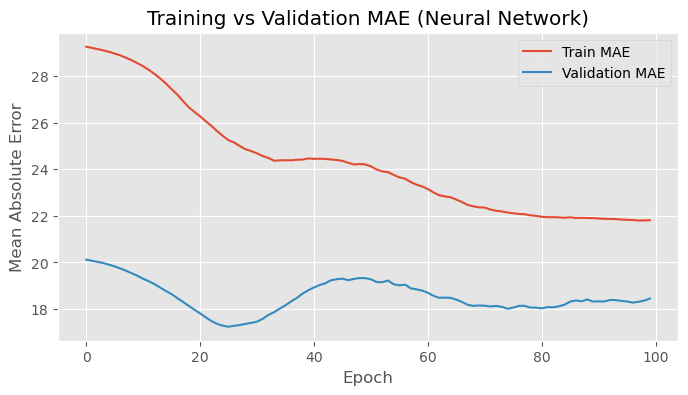

In [133]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MAE (Neural Network)')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()


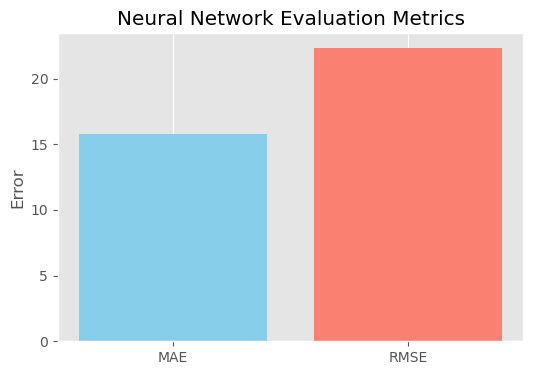

In [134]:
plt.figure(figsize=(6, 4))
plt.bar(['MAE', 'RMSE'], [mae, rmse_nn], color=['skyblue', 'salmon'])
plt.title('Neural Network Evaluation Metrics')
plt.ylabel('Error')
plt.grid(axis='y')
plt.show()


To extend to extra credit, I implemented a simple feedforward neural network using Keras to predict IPO first-day return percentages. The network architecture included two hidden layers (with 16 and 8 neurons respectively, both using ReLU activation) and a single output neuron for regression.

The model was trained on preprocessed data for 100 epochs using the Adam optimizer. After training, it achieved a Test Mean Absolute Error (MAE) of 15.74 and a Test Root Mean Squared Error (RMSE) of 22.33. In comparison, the Ridge regression model yielded a higher Test RMSE of 29.76. This demonstrates that the neural network more effectively captured the complex, non-linear relationships within the data.

Despite the relatively small dataset, which can limit generalization and increase the risk of overfitting, the neural network still delivered superior performance. This result highlights the potential of modern machine learning models to outperform traditional linear approaches when used appropriately and evaluated under consistent metrics.

## References:

- IPO dataset (originally sourced from a public repository or Kaggle. I edited the dataset myself because the original version did not include the categorical variable names, such as the 'Listing_Type' column. I added and labeled these categories to enable proper feature engineering and model training.) https://www.kaggle.com/datasets/divyanshbhatia007/ipo-performance-dataset